# Fine Tuning LLM with DPO and LoRA

Adrian P. Bustamante, Ph.D.\
adrianpebus@gmail.com

### __Table of Contents__

<ol>
    <li><a href="#Data-Processing">Data Processing</a></li>
    <li><a href="#Creating-and-configuring-model,-tokenizer,-LoRA,-and-DPO">Creating and configuring model, tokenizer, LoRA, and DPO </a></li>
    <li><a href="#DPO-training">DPO training</a></li>
    <li><a href="#Generating-Responses">Generating Responses</li>
</ol>

## Objective

The aim of this notebook is to use Direct Preference Optimization (DPO) and Low-Rank Adaptation (LoRA) to fine tune a LLM. We use the 'trl' library and the "ultrafeedback_binarized" dataset from Hugging Face to fine tune the model. The dataset uses a completion criteria based on helpfulness and honesty. Therefore, the aim of the fine-tune is to get more 'helpful and honest' responses from the LLM.

## Data Processing

#### Importing libraries

In [30]:
#!pip install transformers==4.45.2
#!pip install trl==0.11.0 

In [2]:
##imports
import multiprocessing
import os
import requests
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset

from peft import LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer,TrainingArguments, GPT2Tokenizer, set_seed, GenerationConfig
from trl import DPOConfig, DPOTrainer

### About the dataset

We use the "ultrafeedback_binarized" data set on Hugging Face, which is a collection of prompts and responses. See https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized, for details.

Dataset description:\
This is a pre-processed version of the UltraFeedback dataset and was used to train Zephyr-7Β-β, a state of the art chat model at the 7B parameter scale. \
The original UltraFeedback dataset consists of 64k prompts, where each prompt is accompanied with four model completions from a wide variety of open and proprietary models.**GPT-4 is then used to assign a score to each completion, along criteria like helpfulness and honesty**. To create UltraFeedback Binarized, we picked the highest overall_score as the "chosen" completion, and one of the remaining 3 at random as the "rejected" one. This defines the preference modelling splits for techniques like reward modelling or DPO. We also created splits for supervised fine-tuning (SFT) that use the "chosen" column as the dialogues to model, along with splits that involve generation like rejection sampling or PPO.

In [3]:
# Load the dataset
ds = load_dataset("BarraHome/ultrafeedback_binarized")
ds

DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    train_sft: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
    test_sft: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 1000
    })
    train_gen: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_gen: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows

In [4]:
ds.keys()

dict_keys(['train_prefs', 'train_sft', 'test_prefs', 'test_sft', 'train_gen', 'test_gen'])

In [5]:
ds["train_prefs"][0].keys()

dict_keys(['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'])

In [56]:
ds['train_prefs'][3]

{'prompt': 'Which animal has two hands, a hyrax or a dog?',
 'chosen': 'Neither a hyrax nor a dog has hands. Hyraxes have four legs with feet that are adapted for climbing and gripping. Similarly, dogs also have four legs with paws. The term "hands" is usually reserved for primates, such as humans, which have opposable thumbs and fingers.',
 'rejected': 'Both hyraxes and dogs have four limbs. While hyraxes - like their even-toed ungulate relatives the horses and asses - have two rear hands modified for grooming and manipulating objects, dogs have front paws and hind limbs.'}

In [62]:
ds['train_prefs'][5]

{'prompt': 'Write a eulogy for a public figure who inspired you.',
 'chosen': 'Ladies and gentlemen, family and friends, distinguished guests, we gather here today to celebrate the life and legacy of a great leader, an inspirational figure, and a true patriot – the Honorable John Adams.\n\nJohn Adams was a man who dedicated his life to serving his country and advocating for the rights of his fellow citizens. He was a Founding Father, a statesman, a lawyer, a diplomat, and a voracious learner who never ceased to seek knowledge and wisdom. He believed that through education and hard work, anyone could rise above their circumstances and make a positive impact on the world.\n\nAs a member of the Continental Congress, Adams played a critical role in shaping our nation\'s founding documents, including the Declaration of Independence and the U.S. Constitution. He believed that government should exist to serve the needs of its people, and that every person possesses inherent rights that must b

In [8]:
#we reduce the volume of data (due to resource limitations) by selecting the first 500 entries 
#examples from each split of the dataset
for key in ds:
    cnt=500
    ds[key] = ds[key].select(range(cnt))

# Define a function to process the data
## we only keep prompt, chosen, and rejected
def process(row):
    # delete unwanted columns
    del row["prompt_id"]
    del row["messages"]
    del row["score_chosen"]
    del row["score_rejected"]
    # retrieve the actual response text
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]

    return row

# Apply the data processing function to the dataset
ds = ds.map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)

# Split the dataset into training and evaluation sets
train_dataset = ds['train_prefs']
eval_dataset = ds['test_prefs']

Map (num_proc=8): 100%|██████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3574.99 examples/s]


In [9]:
train_dataset, eval_dataset

(Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 500
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 500
 }))

In [10]:
train_dataset[0]

{'prompt': 'how can i develop a habit of drawing daily',
 'chosen': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving your skills gradually.\n4. Use a variety of tools and mediums: Experiment with different tools like pencils, pens, markers, and different mediums like paper, canvas, or digital 

## Creating and configuring model, tokenizer, LoRA, and DPO

#### LLM

In [11]:
# Load the GPT-2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Load a reference model 
model_ref = AutoModelForCausalLM.from_pretrained("gpt2")

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to "right" to fix the overflow issue with FP16 training
tokenizer.padding_side = "right"

# Disable the use of the cache during the model's forward pass
model.config.use_cache = False

In [12]:
##model architecture
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

#### LoRA config

In [13]:
# PEFT (Parameter-Efficient Finetuning) configuration
peft_lora_config = LoraConfig(
        # The rank of the low-rank adaptation weights
        r=4,
        # The target modules to apply the low-rank adaptation to (see model architecture)
        target_modules=['c_proj','c_attn'],
        # The task type for the low-rank adaptation
        task_type="CAUSAL_LM",
        # The scaling factor for the low-rank adaptation weights
        lora_alpha=8,
        # The dropout probability for the low-rank adaptation weights
        lora_dropout=0.1,
        # The bias mode for the low-rank adaptation
        bias="none",
)

#### DPO configuration

In [24]:
# DPO configuration
#from peft import get_peft_model
training_args = DPOConfig(
    # The beta parameter for the DPO loss function (kullback-leibner divergence)
    #beta is the temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5 . 
    beta=0.1,
    # The output directory for the training
    output_dir="dpo",
    # The number of training epochs
    num_train_epochs=10, ##small, because we are using cpu
    # The batch size per device during training
    per_device_train_batch_size=1,
    # The batch size per device during evaluation
    per_device_eval_batch_size=1,
    # Whether to remove unused columns from the dataset
    remove_unused_columns=False,
    # The number of steps between logging training progress
    logging_steps=100, #10,
    # The number of gradient accumulation steps
    gradient_accumulation_steps=1,
    # The learning rate for the optimization
    learning_rate=1e-4,
    # The evaluation strategy (e.g., after each step or epoch)
    #evaluation_strategy="epoch",
    # The number of warmup steps for the learning rate scheduler
    warmup_steps=2,
    # Whether to use 16-bit (float16) precision
    fp16=False,
    # The number of steps between saving checkpoints
    save_steps=500,#500,
    # The maximum number of checkpoints to keep
    #save_total_limit=2,
    # The reporting backend to use (set to 'none' to disable, you can also report to wandb or tensorboard)
    report_to='none'
)

## DPO training

In [25]:
# Create a DPO trainer
# This trainer will handle the fine-tuning of the model using the DPO technique
trainer = DPOTrainer(
        # The model to be fine-tuned
        model=model,
        # The reference model (not used in this case because LoRA has been used)
        ref_model=None,
        # The DPO training configuration
        args=training_args,
        # The training dataset
        train_dataset=train_dataset,
        # The evaluation dataset
        eval_dataset=eval_dataset,
        # The tokenizer for the model
        tokenizer=tokenizer,
        # The PEFT (Parallel Efficient Finetuning) configuration
        peft_config=peft_lora_config,  ##lora_configuration
        # The maximum prompt length
        #max_prompt_length=512,
        # The maximum sequence length
        #max_length=512,
    )

Tokenizing eval dataset: 100%|████████████████████████████████████████████████| 500/500 [00:02<00:00, 216.56 examples/s]


#### we observe the model already has the LoRA layers

In [26]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D(nf=2304, nx=768)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=4, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=4, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (c_proj): lora.Linear(
            (base_layer): Conv1D(nf=768, nx=768)
            (lora_dropout): ModuleDict(
              (default)

#### training the model (fine-tuning)

In [27]:
trainer.train()

Step,Training Loss
100,0.700800
200,0.875300
300,0.905600
400,0.728800
500,0.747600
600,1.116700
700,0.585100
800,0.788600
900,0.800300
1000,0.736100


/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be 

TrainOutput(global_step=5000, training_loss=0.4280859022140503, metrics={'train_runtime': 15475.9211, 'train_samples_per_second': 0.323, 'train_steps_per_second': 0.323, 'total_flos': 0.0, 'train_loss': 0.4280859022140503, 'epoch': 10.0})

In [28]:
log = pd.DataFrame(trainer.state.log_history)

In [29]:
log

,loss,grad_norm,learning_rate,rewards/chosen,rewards/rejected,rewards/accuracies,rewards/margins,logps/rejected,logps/chosen,logits/rejected,logits/chosen,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.7008,3.060678,0.000098,0.361794,0.304932,0.55,0.056862,-413.076874,-538.286621,-101.656624,-102.460472,0.2,100,NaN,NaN,NaN,NaN,NaN
1,0.8753,6.097466,0.000096,1.143791,0.861896,0.54,0.281895,-487.521576,-580.108337,-103.957932,-102.844589,0.4,200,NaN,NaN,NaN,NaN,NaN
2,0.9056,6.806728,0.000094,0.809113,0.858866,0.58,-0.049753,-530.684082,-542.840637,-103.043922,-102.728691,0.6,300,NaN,NaN,NaN,NaN,NaN
3,0.7288,9.384877,0.000092,0.968836,0.793535,0.57,0.175301,-493.781677,-552.282166,-105.499397,-104.786774,0.8,400,NaN,NaN,NaN,NaN,NaN
4,0.7476,34.988960,0.000090,1.532537,0.907743,0.60,0.624793,-412.471954,-488.663940,-104.482361,-103.356308,1.0,500,NaN,NaN,NaN,NaN,NaN
5,1.1167,0.008399,0.000088,1.862740,1.188733,0.74,0.674007,-489.671844,-515.749573,-104.295891,-103.433517,1.2,600,NaN,NaN,NaN,NaN,NaN
6,0.5851,14.250435,0.000086,0.949784,-0.248562,0.75,1.198346,-494.070190,-587.883545,-106.013046,-104.375023,1.4,700,NaN,NaN,NaN,NaN,NaN
7,0.7886,0.003695,0.000084,0.791502,-0.974953,0.73,1.766456,-501.901886,-637.785034,-104.930603,-104.545547,1.6,800,NaN,NaN,NaN,NaN,NaN
8,0.8003,0.163251,0.000082,0.569785,-0.879283,0.70,1.449068,-489.634766,-499.282532,-107.401291,-107.734001,1.8,900,NaN,NaN,NaN,NaN,NaN
9,0.7361,49.338306,0.000080,0.256929,-0.969131,0.67,1.226060,-418.359222,-465.334442,-109.138496,-109.586533,2.0,1000,NaN,NaN,NaN,NaN,NaN


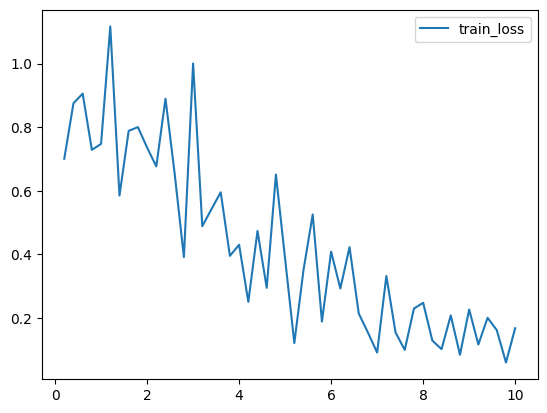

In [30]:
log = pd.DataFrame(trainer.state.log_history)
log_t = log[log['loss'].notna()]
#log_e = log[log['eval_loss'].notna()]

# Plot train and evaluation losses
plt.plot(log_t["epoch"], log_t["loss"], label = "train_loss") 
#plt.plot(log_e["epoch"], log_e["eval_loss"], label = "eval_loss") 
plt.legend() 
plt.show()

## Generating Responses

In [64]:
# Load the last checkpoint of the trained DPO model just trained
dpo_model = AutoModelForCausalLM.from_pretrained('./dpo/checkpoint-5000')


In [67]:
# Set a seed for reproducibility
set_seed(42)
# Define the generation configuration for the DPO model
# This sets the parameters for text generation
generation_config = GenerationConfig(
        # Use sampling to generate diverse text
        do_sample=True,
        # Top-k sampling parameter
        top_k=1,
        # Temperature parameter to control the randomness of the generated text
        temperature=0.1,
        # Maximum number of new tokens to generate
        max_new_tokens=50,
        # Use the end-of-sequence token as the padding token
        pad_token_id=tokenizer.eos_token_id
    )

# Define the input prompt for text generation
PROMPT = "Is a higher octane gasoline better for your car?"
#PROMPT = 'who are you?'
# Encode the prompt using the tokenizer
inputs = tokenizer(PROMPT, return_tensors='pt')

# Generate text using the DPO model
outputs = dpo_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("DPO response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))
print('============================')
# Load the pre-trained GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2')
# Generate text using the GPT-2 model
outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("\nGPT2 response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

DPO response:	 Is a higher octane gasoline better for your car?

Well, it's not necessarily a better one.

A new study from the University of California, San Diego, finds that higher octane gasoline is more effective at reducing emissions than lower octane ones.

The study, which

GPT2 response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is more efficient and more fuel efficient.

The higher octane gasoline is more efficient and more fuel efficient. The higher octane gasoline is more efficient and more fuel efficient. The higher


The dpo model was trained to be more 'helpful and honest', 

#### wrapping up the generators

In [68]:
#TODO
generation_config = GenerationConfig(
    # Use sampling to generate diverse text
    do_sample=True,
    # Top-k sampling parameter: controls the number of highest probability tokens to consider
    top_k=1,
    # Temperature parameter: controls the randomness of the generated text
    temperature=0.1,
    # Maximum number of new tokens to generate
    max_new_tokens=50,  #25,
    # Use the end-of-sequence token as the padding token
    pad_token_id=tokenizer.eos_token_id
)

In [69]:
def generate_dpo_response(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')
    # Generate text using the DPO model
    outputs = dpo_model.generate(**inputs, generation_config=generation_config)
    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_gpt2_response(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate text using the GPT-2 model
    outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
    
    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [70]:
PROMPT = input()
dpo_response = generate_dpo_response(PROMPT)
gpt2_response = generate_gpt2_response(PROMPT)

# Print the responses
print("DPO response:\t", dpo_response)
print('==================')
print("\nGPT-2 response:\t", gpt2_response)

 what is fire?


DPO response:	 what is fire?

Fire is a term used to describe a process that involves burning a substance or liquid. It's usually used to describe a process that involves burning a substance or liquid.

The term fire is derived from the Latin fireus, meaning "

GPT-2 response:	 what is fire?

The fire is the fire that is burning in the world.

The fire is the fire that is burning in the world.

The fire is the fire that is burning in the world.

The fire is the fire that
